# BYOL Analysis - Image and Embedding Loading

This notebook replicates the functionality of `byol_cluster_analysis_macos.py --mode analyze`.
It loads images and extracts embeddings using a trained BYOL model.

In [1]:
cd ../

/Users/kadofong/work/projects/merian/pieridae/scripts/byol


In [2]:
import os
import sys
import torch
import numpy as np
import yaml
from pathlib import Path
from tqdm import tqdm
import logging
import glob
import pickle
import pandas as pd
from torchvision import models, transforms
from torch import nn
from byol_pytorch import BYOL

print("📦 Imports completed successfully")

📦 Imports completed successfully


## Device Setup

Configure device with MPS (Apple Silicon) support if available.

In [3]:
def setup_device():
    """Setup device with MPS support for Apple Silicon"""
    if torch.backends.mps.is_available():
        device = torch.device('mps')
        print(f"✅ Using Apple Silicon GPU (MPS): {device}")
        # Set memory fraction to avoid OOM on limited GPU memory
        torch.mps.set_per_process_memory_fraction(0.8)
    elif torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"✅ Using NVIDIA GPU: {device}")
    else:
        device = torch.device('cpu')
        print(f"Using CPU: {device}")
        # Optimize CPU performance
        torch.set_num_threads(os.cpu_count())
    
    return device

device = setup_device()

✅ Using Apple Silicon GPU (MPS): mps


## Configuration Loading

Load configuration from the YAML file.

In [4]:
def load_config(config_path: str):
    """Load configuration from YAML file"""
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    return config

# Load configuration
config_path = 'byol_config.yaml'
config = load_config(config_path)

# Convert paths to Path objects
config['data']['input_path'] = Path(config['data']['input_path'])
config['data']['output_path'] = Path(config['data']['output_path'])

print(f"📋 Configuration loaded from: {config_path}")
print(f"📁 Input path: {config['data']['input_path']}")
print(f"📁 Output path: {config['data']['output_path']}")
print(f"🖼️  Image size: {config['model']['image_size']}")

📋 Configuration loaded from: byol_config.yaml
📁 Input path: ../../local_data/pieridae_output/starlet/msorabove_v0
📁 Output path: ../../local_data/byol_results
🖼️  Image size: 150


## Data Loading

Load images using the same pattern as the cluster analysis script.

In [5]:
def load_data(data_path: Path):
    """Load image data from pickle files (same as cluster script)"""
    print(f"🔍 Loading image data from: {data_path}")
    
    pattern = f"{data_path}/M*/*i_results.pkl"
    filenames = glob.glob(pattern)
    
    if not filenames:
        raise FileNotFoundError(f"No files found matching pattern: {pattern}")
    
    print(f"📸 Found {len(filenames)} image files")
    
    imgs = []
    img_names = []
    
    for fname in tqdm(filenames, desc="Loading images"):
        img = []
        for band in 'gi':
            current_filename = fname.replace('_i_', f'_{band}_')
            
            try:
                with open(current_filename, 'rb') as f:
                    xf = pickle.load(f)
                    img.append(xf['image'])
                    if band == 'i':
                        img.append(xf['hf_image'])
            except FileNotFoundError:
                print(f"⚠️  File not found: {current_filename}")
                continue
        
        if len(img) == 3:  # Only add if we have all bands
            imgs.append(np.array(img))
            img_names.append(Path(fname).parent.name)
    
    images = np.array(imgs)
    img_names = np.array(img_names)
    
    print(f"✅ Loaded {len(images)} images with shape: {images.shape}")
    return images, img_names

# Load images
images, img_names = load_data(config['data']['input_path'])

🔍 Loading image data from: ../../local_data/pieridae_output/starlet/msorabove_v0
📸 Found 22913 image files


Loading images: 100%|████████████████████| 22913/22913 [00:45<00:00, 506.02it/s]


✅ Loaded 22913 images with shape: (22913, 3, 150, 150)


## BYOL Model Setup

Initialize the BYOL model with the same configuration used for training.

In [6]:
def setup_byol_model(config, device):
    """Setup BYOL model for inference"""
    print("🤖 Setting up BYOL model...")
    
    # Data augmentations (same as training)
    transform1 = nn.Sequential(
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=180),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
    )
    
    transform2 = nn.Sequential(
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=180),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
    )
    
    # Base model - use ResNet18 for compatibility
    resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    
    # BYOL learner
    learner = BYOL(
        resnet,
        image_size=config['model']['image_size'],
        hidden_layer='avgpool',
        projection_size=config['model']['projection_size'],
        projection_hidden_size=config['model']['projection_hidden_size'],
        moving_average_decay=config['model']['moving_average_decay'],
        use_momentum=True,
        augment_fn=transform1,
        augment_fn2=transform2
    ).to(device)
    
    print(f"✅ BYOL model setup complete on {device}")
    return learner

# Setup model
learner = setup_byol_model(config, device)

🤖 Setting up BYOL model...
✅ BYOL model setup complete on mps


## Load Trained Model Weights

Load the trained BYOL model from checkpoint.

In [7]:
def load_trained_model(learner, output_path: Path, device):
    """Load trained model weights"""
    model_path = output_path / 'byol_final_model.pt'
    
    if not model_path.exists():
        # Try checkpoint instead
        model_path = output_path / 'model_checkpoint.pt'
        
    if not model_path.exists():
        raise FileNotFoundError(f"No trained model found in {output_path}")
    
    print(f"📥 Loading trained model from: {model_path}")
    
    try:
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
        
        if 'model_state_dict' in checkpoint:
            learner.load_state_dict(checkpoint['model_state_dict'])
            print(f"✅ Model loaded successfully")
        else:
            # Direct state dict
            learner.load_state_dict(checkpoint)
            print(f"✅ Model loaded successfully (direct state dict)")
            
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        raise
    
    learner.eval()
    return learner

# Load trained model
learner = load_trained_model(learner, config['data']['output_path'], device)

📥 Loading trained model from: ../../local_data/byol_results/byol_final_model.pt
✅ Model loaded successfully


## Extract Embeddings

Extract embeddings from all loaded images using the trained BYOL model.

In [8]:
def extract_embeddings(learner, images, device, batch_size=128):
    """Extract embeddings from images using trained BYOL model"""
    print(f"🧠 Extracting embeddings from {len(images)} images...")
    
    learner.eval()
    all_embeddings = []
    
    # Adjust batch size for device capabilities
    if device.type == 'mps':
        batch_size = min(64, batch_size)  # Reduce for MPS
    
    num_batches = (len(images) + batch_size - 1) // batch_size
    
    with torch.no_grad():
        for i in tqdm(range(num_batches), desc="Extracting embeddings"):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(images))
            
            # Prepare batch
            batch = torch.tensor(
                images[start_idx:end_idx],
                dtype=torch.float32
            ).to(device)
            
            try:
                # Extract embeddings
                _, embeddings = learner(batch, return_embedding=True)
                all_embeddings.append(embeddings.cpu().numpy())
                
            except RuntimeError as e:
                if "MPS" in str(e) and device.type == 'mps':
                    print(f"⚠️  MPS error, falling back to CPU for batch {i}")
                    # Fallback to CPU for this batch
                    batch = batch.cpu()
                    learner_cpu = learner.cpu()
                    _, embeddings = learner_cpu(batch, return_embedding=True)
                    all_embeddings.append(embeddings.cpu().numpy())
                    # Move learner back to original device
                    learner = learner.to(device)
                else:
                    raise e
    
    # Combine all embeddings
    embeddings = np.vstack(all_embeddings)
    print(f"✅ Extracted embeddings shape: {embeddings.shape}")
    
    return embeddings

# Extract embeddings
embeddings = extract_embeddings(
    learner, 
    images, 
    device, 
    batch_size=config['inference']['batch_size']
)

🧠 Extracting embeddings from 22913 images...


Extracting embeddings: 100%|██████████████████| 359/359 [00:39<00:00,  9.08it/s]


✅ Extracted embeddings shape: (22913, 512)


## Dimensionality Reduction (PCA + UMAP)

Apply PCA and UMAP to the embeddings for visualization.

In [9]:
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def compute_pca_umap(embeddings, config):
    """Apply PCA and UMAP to embeddings"""
    print("🔄 Computing PCA and UMAP...")
    
    # Clean data
    embeddings_clean = np.nan_to_num(
        embeddings, nan=0.0, posinf=0.0, neginf=0.0
    )
    
    # Standardization
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings_clean)
    
    # PCA
    pca_components = config['analysis']['pca_components']
    if pca_components is None:
        # Auto-determine based on variance threshold
        pca_full = PCA()
        pca_full.fit(embeddings_scaled)
        cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
        threshold = config['analysis']['explained_variance_threshold']
        pca_components = np.argmax(cumsum_var >= threshold) + 1
    
    max_components = min(
        embeddings_scaled.shape[0] - 1,
        embeddings_scaled.shape[1]
    )
    pca_components = min(pca_components, max_components)
    
    pca = PCA(n_components=pca_components, random_state=42)
    embeddings_pca = pca.fit_transform(embeddings_scaled)
    
    # UMAP
    n_neighbors = min(
        config['analysis']['n_neighbors'],
        len(embeddings_pca) - 1
    )
    
    umap_reducer = umap.UMAP(
        n_components=config['analysis']['umap_components'],
        n_neighbors=n_neighbors,
        min_dist=config['analysis']['min_dist'],
        metric=config['analysis']['metric'],
        random_state=42,
        verbose=True
    )
    
    embeddings_umap = umap_reducer.fit_transform(embeddings_pca)
    
    print(f"✅ PCA components: {pca_components}")
    print(f"✅ UMAP embedding shape: {embeddings_umap.shape}")
    
    return {
        'scaler': scaler,
        'pca': pca,
        'umap': umap_reducer,
        'embeddings_original': embeddings_clean,
        'embeddings_pca': embeddings_pca,
        'embeddings_umap': embeddings_umap
    }

# Compute PCA and UMAP
reduction_results = compute_pca_umap(embeddings, config)
pca = reduction_results['pca']
print(f'Explained variance: {pca.explained_variance_ratio_.sum()*100:.1f} pct')

/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


🔄 Computing PCA and UMAP...


/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(min_dist=0.01, n_jobs=1, random_state=42, verbose=True)
Mon Oct 13 11:13:30 2025 Construct fuzzy simplicial set
Mon Oct 13 11:13:30 2025 Finding Nearest Neighbors
Mon Oct 13 11:13:30 2025 Building RP forest with 13 trees
Mon Oct 13 11:13:34 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Mon Oct 13 11:13:40 2025 Finished Nearest Neighbor Search
Mon Oct 13 11:13:41 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Oct 13 11:13:53 2025 Finished embedding
✅ PCA components: 10
✅ UMAP embedding shape: (22913, 2)
Explained variance: 85.2 pct


## Load Classification Labels

Load the classification labels for creating the fraction maps.

In [10]:
def load_labels(config, img_names):
    """Load classification labels"""
    labels = None
    label_file = Path(config.get('labels', {}).get('classifications_file', './classifications_kadofong_20250929.csv'))
    print(label_file)
    if label_file.exists() and img_names is not None:
        try:
            mergers = pd.read_csv(label_file, index_col=0)
            labels = mergers.reindex(img_names)
            labels = labels.replace(np.nan, 0).values.flatten().astype(int)
            print(f"✅ Loaded classification labels: {len(labels)} objects")
            
            # Print label distribution
            unique, counts = np.unique(labels, return_counts=True)
            label_meanings = {
                0: "unclassified", 1: "undisturbed", 2: "ambiguous",
                3: "merger", 4: "fragmentation", 5: "artifact"
            }
            
            print("📊 Label distribution:")
            for label_val, count in zip(unique, counts):
                meaning = label_meanings.get(label_val, f"unknown_{label_val}")
                print(f"   {label_val} ({meaning}): {count} objects")
                
        except Exception as e:
            print(f"⚠️  Could not load labels: {e}")
            labels = None
    else:
        print(f"⚠️  Label file not found: {label_file}")
        labels = None
    
    return labels

# Load labels
labels = load_labels(config, img_names)

classifications_kadofong_current.csv
✅ Loaded classification labels: 22913 objects
📊 Label distribution:
   0 (unclassified): 19960 objects
   1 (undisturbed): 2314 objects
   2 (ambiguous): 214 objects
   3 (merger): 96 objects
   4 (fragmentation): 280 objects
   5 (artifact): 49 objects


# Use PCA to estimate labels

In [11]:
import matplotlib.pyplot as plt
from astropy.visualization import make_lupton_rgb
from matplotlib import colors
from ekfplot import plot as ek
from scipy import ndimage

from sklearn.neighbors import NearestNeighbors

In [12]:
pca_embeddings = reduction_results['embeddings_pca']

nbrs = NearestNeighbors(n_neighbors=50, algorithm='ball_tree').fit(pca_embeddings)

distances, indices = nbrs.kneighbors(pca_embeddings)
distances[:,0] = np.nan

In [13]:
n_min = config.get('labels', {}).get('minimum_labeled_neighbors', 8)
print(f'Using minimum_labeled_neighbors = {n_min} from config')

Using minimum_labeled_neighbors = 5 from config


In [14]:
neighbor_labels = labels[indices]

weights = np.where( neighbor_labels>0, 1./distances, 0. )
weights /= np.nansum(weights,axis=1).reshape(-1,1)

prob_labels = np.zeros([pca_embeddings.shape[0], labels.max()+1])

for ix in range(labels.max()+1):
    prob_labels[:,ix] = np.nansum(np.where(neighbor_labels==ix, weights, 0),axis=1)
n_labels = np.sum(neighbor_labels>0,axis=1)


prob_labels[n_labels<n_min] = 0.
print(f'{(prob_labels>0).any(axis=1).sum()} galaxies have auto-labels')

iterative_labels = labels.copy ()

# iterate over relatively certain labels
n_new = 1
while n_new > 0:
    neighbor_labels = iterative_labels[indices]
    n_labels = np.sum(neighbor_labels>0,axis=1)
    n_labeled = (iterative_labels>0).sum()
    n_min_auto = 15
    
    additions = np.where(prob_labels[n_labels>=n_min_auto] > 0.9)
    new_labels = np.zeros_like(iterative_labels)
    new_labels[additions[0]] = additions[1]
    
    new_labels[(prob_labels[:,4]>0.4)&(n_labels>=n_min_auto)] = 4
    
    iterative_labels[iterative_labels==0] = new_labels[iterative_labels==0]
    is_iterative = labels != iterative_labels
    n_new = (iterative_labels>0).sum() - n_labeled
    print(f'{(labels>0).sum()} human labels')
    print(f'{n_new} auto-labels added, {(iterative_labels>0).sum()} labels total')
    break

neighbor_labels = iterative_labels[indices]

weights = np.where( neighbor_labels>0, 1./distances, 0. )
weights[is_iterative] *= 0.1
weights /= np.nansum(weights,axis=1).reshape(-1,1)

prob_labels = np.zeros([pca_embeddings.shape[0], labels.max()+1])

for ix in range(labels.max()+1):
    prob_labels[:,ix] = np.nansum(np.where(neighbor_labels==ix, weights, 0),axis=1)
n_labels = np.sum(neighbor_labels>0,axis=1)

prob_labels[n_labels<n_min] = 0.
print(f'{(prob_labels>0).any(axis=1).sum()} galaxies have auto-labels')

15227 galaxies have auto-labels
2953 human labels
289 auto-labels added, 3242 labels total
17052 galaxies have auto-labels


/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_3314/980433598.py:4: RuntimeWarning: invalid value encountered in divide
  weights /= np.nansum(weights,axis=1).reshape(-1,1)


In [15]:
is_merger = ((prob_labels[:,2]+prob_labels[:,3])>prob_labels[:,1])&(prob_labels[:,4]<0.3)

/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_3314/2802391633.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['','undisturbed','ambiguous','merger','fragmented'], rotation=35)


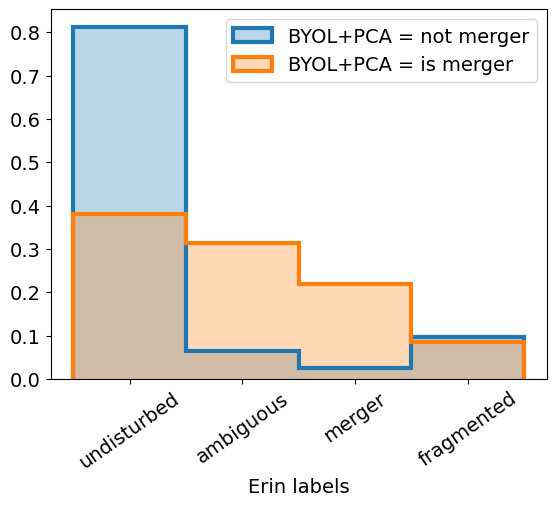

In [16]:
ax = plt.subplot(111)
ek.hist(labels[~is_merger], bins=np.arange(0.5,5), density=True, lw=3, alpha=0.3, label='BYOL+PCA = not merger')
ek.hist(labels[is_merger], bins=np.arange(.5,5), density=True, lw=3, alpha=0.3, label='BYOL+PCA = is merger')
ax.set_xticklabels(['','undisturbed','ambiguous','merger','fragmented'], rotation=35)
ax.set_xlabel('Erin labels')
plt.legend ()

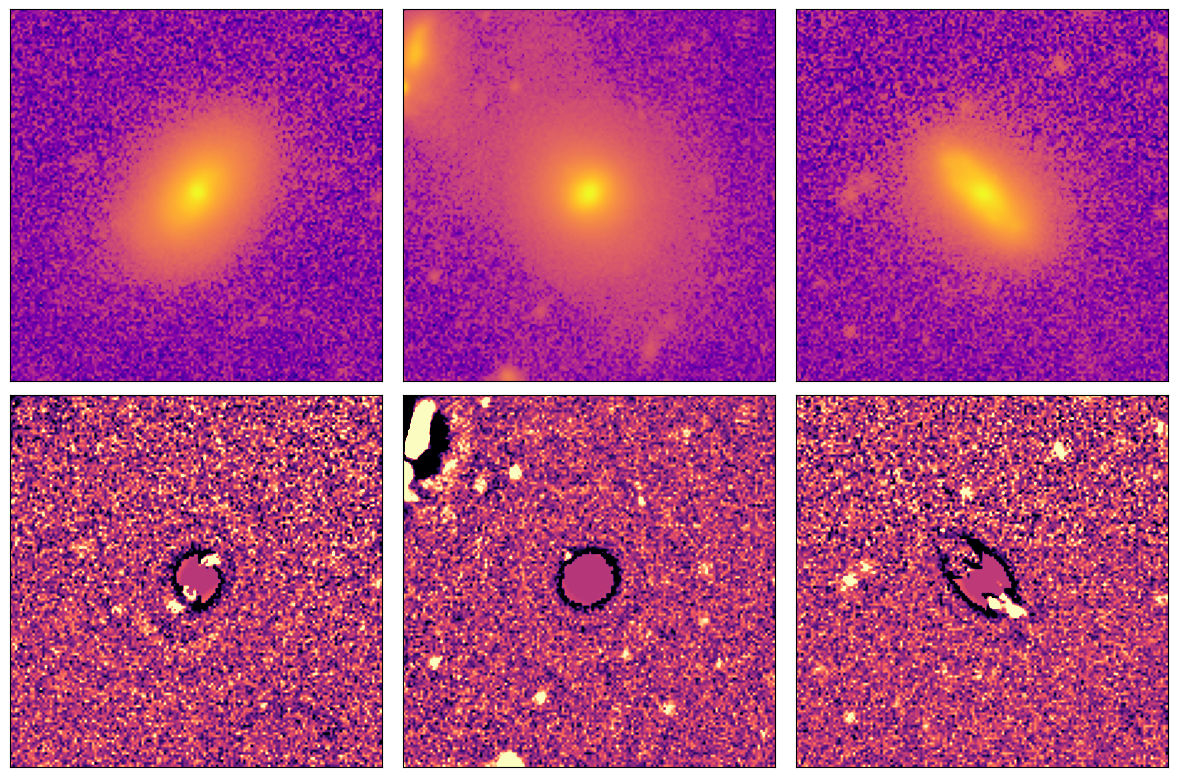

In [17]:
fig, axarr = plt.subplots(2,3,figsize=(12,8))

for aix,idx in enumerate(range(min(3, ((labels==1)&is_merger).sum()))):
    nm = ((labels==1)&is_merger).sum()
    index = np.random.randint(0,nm-1)
    im = images[(labels==1)&is_merger][index,1]
    axarr[0,aix].imshow(
        im,# - ndimage.gaussian_filter(im,3), 
        #ax=axarr[0,aix],
        cmap='plasma',
        norm=colors.SymLogNorm(linthresh=0.1),
        origin='lower',
    )
    ek.imshow(images[(labels==1)&is_merger][index,2], ax=axarr[1,aix], cmap='magma')

for ax in axarr.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout ()

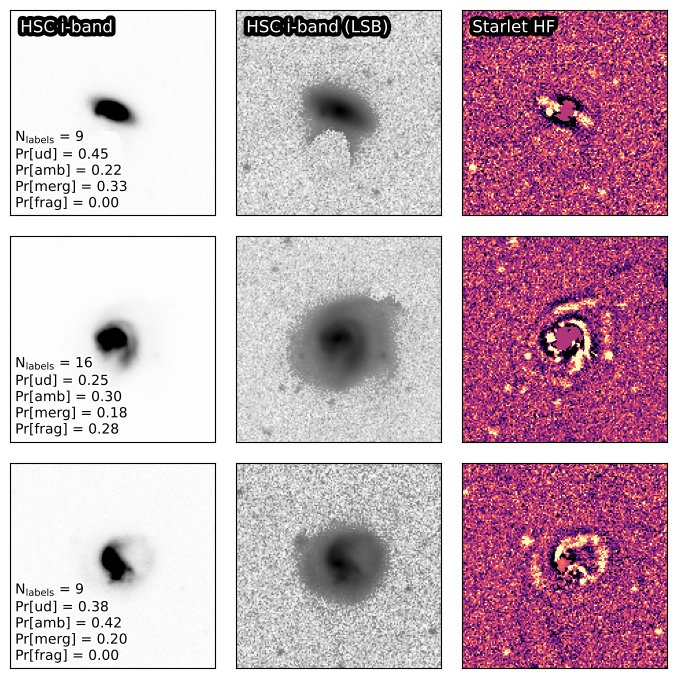

In [18]:
generate_paper_figure = True

fig, axarr = plt.subplots(3, 3, figsize=(7,7))
axarr = axarr.T

fragmented = (prob_labels[:,4] > 0.3)
possible_merger = (prob_labels[:,3] + prob_labels[:,2]) > (prob_labels[:,1])

#possible_merger &= n_labels >= 5
#is_lowmass = catalog.reindex(img_names)['logmass_adjusted'] < 8.5

candidates = np.arange(prob_labels.shape[0])[possible_merger&~fragmented]
#candidates = candidates[np.argsort(n_labels[possible_merger&~fragmented])][::-1]
candidates = candidates[np.random.randint(0, len(candidates), 3)]
for idx, gix in enumerate(candidates[:3]):
    ek.imshow(
        images[gix][1],
        ax=axarr[0, idx],
        q=0.01,
        cmap='Greys'
    )
    axarr[1,idx].imshow(
        images[gix][1],
        #ax=axarr[1, idx],
        origin='lower',
        cmap='Greys',
        norm=colors.SymLogNorm(linthresh=0.1)
    )

    ek.imshow(
        images[gix][2],
        ax=axarr[2, idx],
        #q=0.05,
        cmap='magma'
    )
    ek.text(
        0.025,
        0.025,
        rf'''N$_{{\rm labels}}$ = {n_labels[gix]}
Pr[ud] = {prob_labels[gix,1]:.2f}
Pr[amb] = {prob_labels[gix,2]:.2f}
Pr[merg] = {prob_labels[gix,3]:.2f}
Pr[frag] = {prob_labels[gix,4]:.2f}''',
       ax=axarr[0,idx],
        fontsize=10, 
        bordercolor='w', color='k', borderwidth=3
    )

for ix,ax in enumerate(axarr.flatten()):
    ax.set_xticks([])
    ax.set_yticks([])
if not generate_paper_figure:
    for ix, ax in enumerate(axarr[0]):
        ek.text(0.05, 0.95, img_names[candidates[ix]], ax=ax, fontsize=8, bordercolor='k', color='w', borderwidth=6 )
if generate_paper_figure:
    ek.text(0.05,0.95, 'HSC i-band', ax=axarr[0,0], fontsize=12, bordercolor='k', color='w', borderwidth=6 )
ek.text(0.05,0.95, 'HSC i-band (LSB)', ax=axarr[1,0], fontsize=12, bordercolor='k', color='w', borderwidth=6 )
ek.text(0.05,0.95, 'Starlet HF', ax=axarr[2,0], fontsize=12, bordercolor='k', color='w', borderwidth=6 )

plt.tight_layout ()
#plt.savefig('/Users/kadofong/Downloads/examples.png')

In [19]:
sid = img_names[candidates[1]]
with open(f'../../local_data/pieridae_output/starlet/msorabove_v0/{sid}/{sid}_i_results.pkl', 'rb') as f:
    x = pickle.load(f)

In [20]:
from ekfstats import fit

In [21]:
sersic = fit.fit_sersic_2d(x['image'], )

15.0


(<matplotlib.image.AxesImage at 0x38aa4bb20>, <Axes: >)

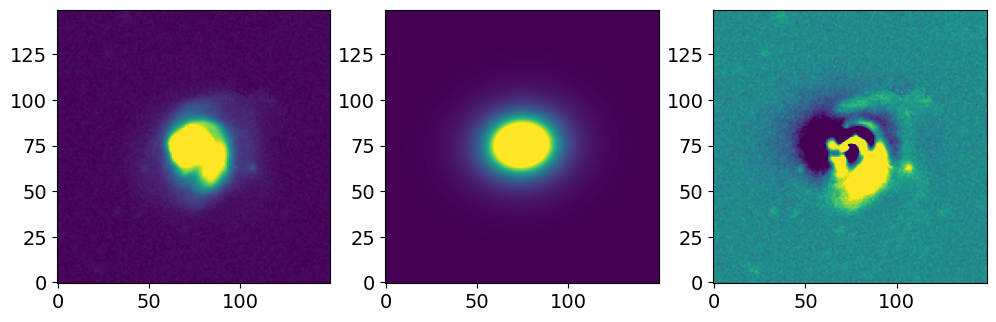

In [22]:
fig, axarr = plt.subplots(1,3,figsize=(12,4))
ek.imshow(x['image'], ax=axarr[0])
ek.imshow(sersic[1], ax=axarr[1])
ek.imshow(x['image'] - sersic[1], ax=axarr[2])

# Look at merger statistics

In [23]:
from ekfplot import colors as ec, plot as ek
from ekfphys import calibrations
from pieridae.starbursts import sample


In [ ]:
full_catalog, masks = sample.load_sample(
    '/Users/kadofong/work/projects/merian/local_data/base_catalogs/mdr1_n708maglt26_and_pzgteq0p1.parquet'
)
base_catalog = full_catalog.loc[masks['is_good'][0]]

datadir = '../../local_data/pieridae_output/starlet/msorabove_v0/'
for sid in tqdm(base_catalog.index):
    filename = f'{datadir}/{sid}/{sid}_i_results.pkl'
    if not os.path.exists(filename):
        continue
    with open(filename, 'rb') as f:
        x = pickle.load(f)
    base_catalog.loc[sid, 'logmass_adjusted'] = x['logmass_adjusted']
base_catalog.loc[base_catalog['logmass_adjusted'].isna(),'logmass_adjusted'] = base_catalog.loc[base_catalog['logmass'].isna(),'logmass_adjusted']

fragmented = prob_labels[:,4] > 0.3
prob_merger = (prob_labels[:,2]+prob_labels[:,3]) > prob_labels[:,1]

catalog = base_catalog.reindex(img_names[~fragmented])
catalog['p_merger'] = np.where((prob_labels[~fragmented]==0).all(axis=1), np.nan, prob_labels[~fragmented,3])
catalog['p_ambig'] = np.where((prob_labels[~fragmented]==0).all(axis=1), np.nan, prob_labels[~fragmented,2])
catalog['p_undisturbed'] = np.where((prob_labels[~fragmented]==0).all(axis=1), np.nan, prob_labels[~fragmented,1])

dm = catalog['logmass_adjusted'] - catalog['logmass']
catalog = catalog.loc[dm < 0.5]

/Users/kadofong/work/ekfutils/ekfplot/ekfplot/plot.py:494: RuntimeWarning: invalid value encountered in divide
  im=ax.pcolormesh(bins[0], bins[1], (weighted_counts/raw_counts).T, cmap=cmap, **kwargs)


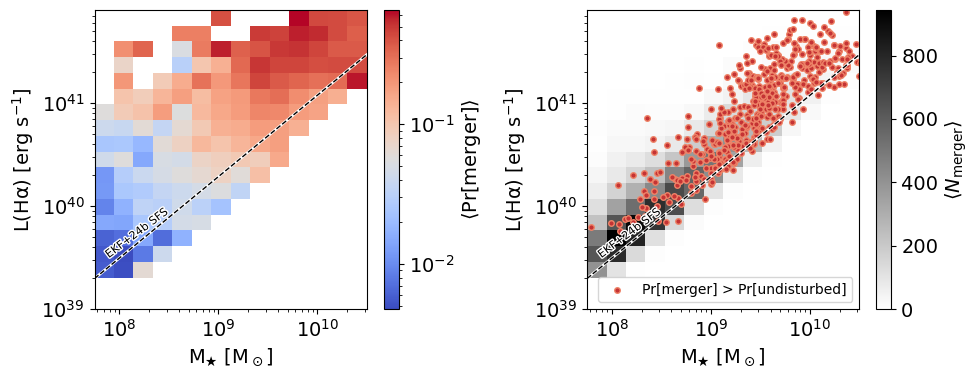

In [29]:
fig, axarr = plt.subplots(1,2,figsize=(10,4))

bins = [np.logspace(7.75, 10.5,15), np.logspace(39,41.9,20)]
im,_=ek.pcolor_avg2d(
    10.**catalog['logmass_adjusted'], 
    catalog['L_Ha'],
    catalog['p_merger']+catalog['p_ambig'],
    cmap='coolwarm',
    yscale='log',
    xscale='log',
    zscale='log',
    bins=bins,
    ax=axarr[0],
    #vmax=0.35,
    #vmin=0.01
    #s=3,
    #cmap=ec.ColorBase('tab:red').sequential_cmap(fade=1.)
)

imx=ek.hist2d(
    10.**catalog['logmass_adjusted'], 
    catalog['L_Ha'],
    cmap=ec.ColorBase('k').sequential_cmap(fade=1.),
    yscale='log',
    xscale='log',
    #zscale='log',
    bins=bins,
    ax=axarr[1],
    #cmap=ec.ColorBase('tab:red').sequential_cmap(fade=1.)
)

#imx=ek.hist2d(
#    10.**catalog['logmass_adjusted'], 
#    catalog['L_Ha'],
#    weights=np.where(np.isnan(catalog['p_merger']+catalog['p_ambig']),0., catalog['p_merger']+catalog['p_ambig']),
#    cmap=ec.ColorBase('tab:red').sequential_cmap(fade=0.),
#    yscale='log',
#    xscale='log',
#    #zscale='log',
#    bins=bins,
#    ax=axarr[1],
#    #cmap=ec.ColorBase('tab:red').sequential_cmap(fade=1.)
#)
probable_merger = (catalog['p_ambig']+catalog['p_merger'])>catalog['p_undisturbed']
axarr[1].scatter(
    10.**catalog.loc[probable_merger,'logmass_adjusted'], 
    catalog.loc[probable_merger, 'L_Ha'],
    fc=plt.cm.coolwarm(.95),
    ec=plt.cm.coolwarm(0.8),
    s=4**2,
    label=r'Pr[merger] > Pr[undisturbed]'
)
axarr[1].legend(loc='lower right', fontsize=10)

ms = im._coordinates.data[0,:,0]
alpha = -0.13*0.08 + 0.8
norm = 1.24*0.08 - 1.47
sfs = 10.**(alpha*(np.log10(ms) - 8.5) + norm)
ha_sfs = calibrations.SFR2LHa(sfs)
plt.colorbar(imx[0][-1],ax=axarr[1], label=r'$\langle N_{\rm merger} \rangle$')
plt.colorbar(im,ax=axarr[0], label=r'$\langle {\rm Pr[merger]}\rangle$')

for ax in axarr:
    ek.outlined_plot(
        ms,
        ha_sfs,
        ax=ax,
        lw=1,
        ls='--',
    )
    
    ek.text(
        7e7,
        3e39,
        'EKF+24b SFS',
        ax=ax,
        rotation=37,
        coord_type='absolute',
        va='bottom',
        ha='left',
        bordercolor='w',
        borderwidth=2,
        fontsize=8,        
    )    
    ax.set_xlabel(ek.common_labels['mstar'])
    ax.set_ylabel(ek.common_labels['halum'])
    ek.loglog(ax=ax)

#prob_merger = (catalog['p_merger']+catalog['p_ambig']) > catalog['p_undisturbed']
#axarr[0].scatter(
#    10.**catalog.loc[prob_merger, 'logmass_adjusted'],
#    catalog.loc[prob_merger, 'L_Ha'],
#    color='lime'
#)
plt.tight_layout ()
plt.savefig('/Users/kadofong/work/papers/journal/MerianStarbursts/figures/pmerger_sfs.pdf')

In [30]:
from ekfstats import sampling

from astroML.density_estimation import knuth_bin_width

In [31]:
def gotoscinot(value):
    power = int(np.floor(value))
    leading = 10.**(value - np.floor(value))
    return rf'{leading:.0f}$\times10^{{{power}}}$'

/Users/kadofong/work/ekfutils/ekfstats/ekfstats/sampling.py:949: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_x = x[sortmask]
        Use astropy.stats.knuth_bin_width instead. [warnings]


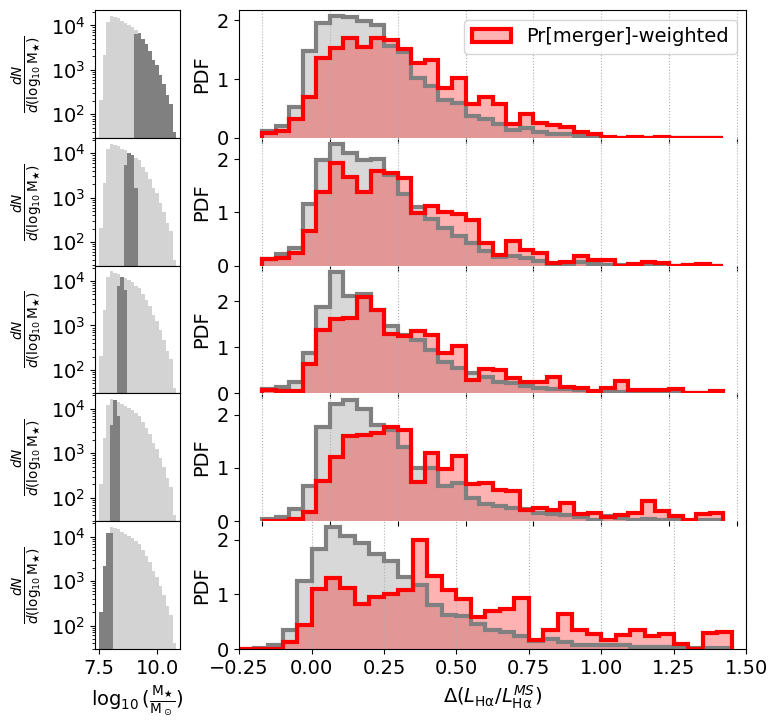

In [34]:
alpha = -0.13*0.08 + 0.8
norm = 1.24*0.08 - 1.47
sfs_at_mass = 10.**(alpha*(catalog['logmass_adjusted'] - 8.5) + norm)
ha_sfs_at_mass = calibrations.SFR2LHa(sfs_at_mass)
mbins = np.arange(7.5, 10.8,0.15)

groups, logmstar_bins = sampling.bin_by_count(catalog['logmass_adjusted'], 4000, dx_min=0.1)

groupids = np.unique(groups,)
ngroups = groupids.size
fig, f_axarr = plt.subplots(ngroups, 2, figsize=(8,1.5*ngroups), gridspec_kw={'width_ratios':(1,6)})
axarr = f_axarr[:,1]

for idx,gid in enumerate(groupids[::-1]):
    #ms_at_mass = np.interp( 0.5*(logmstar_bins[gid-1]+logmstar_bins[gid]), np.log10(ms), np.log10(ha_sfs) )
    ms_at_mass = np.interp ( catalog.loc[groups==gid, 'logmass_adjusted'], np.log10(ms), np.log10(ha_sfs) )
    dx,bins = knuth_bin_width(np.log10(catalog.loc[groups==gid, 'L_Ha']) - ms_at_mass, return_bins=True)
    hkwargs = {'alpha':.3,'lw':3, 'bins':np.arange(-0.25,1.5, 0.05), 'density':True, 'ax':axarr[idx]}
    
    logmbounds = logmstar_bins[gid-1], logmstar_bins[gid]
    
    pmerger = catalog['p_merger']+catalog['p_ambig']
    bkgcolor = ec.ColorBase('grey')#.modulate(0.1, -0.4)
    
    ek.hist( np.log10(catalog.loc[groups==gid, 'L_Ha']) - ms_at_mass, color=bkgcolor.base, **hkwargs)
    ek.hist( np.log10(catalog.loc[groups==gid, 'L_Ha']) - ms_at_mass, color='r', label='Pr[merger]-weighted',
             weights=pmerger.loc[groups==gid], **hkwargs)
    #ek.hist( np.log10(catalog.loc[groups==gid, 'L_Ha']) - ms_at_mass, 
    #         weights=np.where(pmerger>0.25,1.,0.)[groups==gid], **hkwargs)

    dm = np.diff(mbins)[0]
    ek.hist(catalog['logmass_adjusted'], bins=mbins, weights=np.full(len(catalog), 1./dm), ax=f_axarr[idx, 0], color='lightgrey')

    mmask = (catalog['logmass_adjusted']>logmbounds[0])&(catalog['logmass_adjusted']<=logmbounds[1])
    ek.hist(catalog.loc[mmask,'logmass_adjusted'], color=bkgcolor.base, ax=f_axarr[idx,0], bins=mbins, weights=np.full(mmask.sum(),1./dm))
axarr[0].legend(loc='upper right')
plt.xlim(-0.25,1.5)
axarr[-1].set_xlabel(r'$\Delta (L_{\rm H\alpha}/L_{\rm H\alpha}^{MS})$')
for ax in axarr:
    #ax.set_ylabel('PD)
    ax.set_facecolor((1, 1, 1, 0))
    ax.grid('lightgrey', ls=':', axis='x', which='both')
    ax.set_ylabel('PDF')
    #ax.set_yticks([])
for ax in axarr[1:]:
    ax.spines[['top']].set_visible(False)
for ax in axarr[:-1]:
    ax.spines[['bottom']].set_visible(False)    
    ax.set_xticklabels([])
for ax in f_axarr[:,0]:    
    #ax.set_yticks([])
    ax.set_yscale('log')
    ax.set_ylabel(r'$\frac{dN}{d(\log_{10} \rm M_\bigstar)}$')
for ax in f_axarr[:-1,0]:
    ax.set_xticks([])
f_axarr[-1,0].set_xlabel(r'$\log_{10} (\frac{\rm M_\bigstar}{M_\odot})$')

plt.tight_layout ()
plt.subplots_adjust(hspace=0., wspace=0.2)

plt.savefig('/Users/kadofong/work/papers/journal/MerianStarbursts/figures/lha_ms_pdfs.pdf', bbox_inches='tight')

In [57]:
from astropy import coordinates, units as u
from astropy import cosmology 
from ekfstats import galstats
cosmo = cosmology.FlatLambdaCDM(70.,0.3)

In [ ]:
massive_galaxies = base_catalog.query('logmass_adjusted>10.')

allcoords = coordinates.SkyCoord(base_catalog.query('pz>0.26')['RA'],base_catalog.query('pz>0.26')['DEC'], unit='deg')
allcoords_nooverlap = allcoords.copy()
too_close = np.array([True])
tcoords = coordinates.SkyCoord(catalog['RA'], catalog['DEC'], unit='deg')

while too_close.any():
    match_idx, d2d, _ = allcoords_nooverlap.match_to_catalog_sky(tcoords, nthneighbor=1, )
    too_close = d2d <= (10*u.arcsec)
    allcoords_nooverlap = allcoords_nooverlap[~too_close]

mcoords = coordinates.SkyCoord(massive_galaxies['RA'],massive_galaxies['DEC'], unit='deg')


nmc = 100

p_environment = np.zeros([nmc, len(catalog), 3])
for _ in tqdm(range(nmc)):
    catalog['z'] = np.where(np.isnan(catalog['z_spec']), np.random.uniform(0.06, 0.1, len(catalog)), catalog['z_spec'])
    massive_galaxies['z'] =  np.where(np.isnan(massive_galaxies['z_spec']), np.random.uniform(0.06, 0.1, len(massive_galaxies)), massive_galaxies['z_spec'])
    envdict = galstats.classify_environment_fast(catalog, massive_galaxies, return_separations=False, verbose=0)
    p_environment[_,:,0] = envdict['satellite']
    p_environment[_,:,1] = envdict['central']
    p_environment[_,:,2] = envdict['isolated']

In [ ]:
pmerger = catalog.loc[:, 'p_merger'] + catalog.loc[:, 'p_ambig']

pm_avg = np.array([ np.nansum(pmerger.values*p_environment[:,:,ix], axis=1) / np.nansum(np.isfinite(pmerger.values)*p_environment[:,:,ix],axis=1) for \
                ix in range(3) ])

ax = plt.subplot(111)
ek.errorbar(
    np.arange(3),
    np.median(pm_avg,axis=1),
    ylow=np.quantile(pm_avg, 0.16, axis=1),
    yhigh=np.quantile(pm_avg, 0.84, axis=1),
    capsize=3
)
ax.set_xticks([0,1,2], ['satellite','central','isolated'])

Text(0.5, 0, 'Distance to Nth neighbor (kpc)')

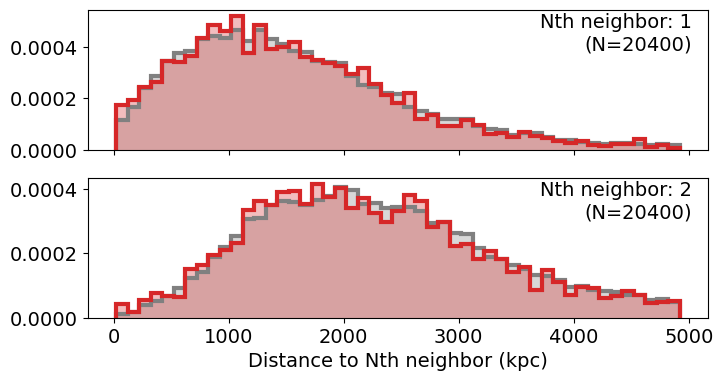

In [56]:
# Define the range of Nth neighbors to examine
neighbor_values = np.array([1,2])  # Adjust as needed
n_neighbors = neighbor_values.size

fig, axarr = plt.subplots(n_neighbors, 1, figsize=(8, 2.*n_neighbors), sharex=True)

# Convert factor once (assuming constant redshift)
factor = cosmo.kpc_proper_per_arcmin(0.08)

# Compute merger probability
pmerger = catalog['p_merger'] + catalog['p_ambig']

for i, ix in enumerate(neighbor_values):
    # Match to Nth nearest neighbor
    match_idx, d2d, _ = tcoords.match_to_catalog_sky(mcoords, nthneighbor=ix)
    
    # Convert distances to kpc
    distances_kpc = d2d.to('arcmin').value * factor.value
    
    # Histogram kwargs
    hkwargs = {'alpha': .3, 'lw': 3, 'bins': np.arange(20, 5000, 100), 
               'density': True, 'ax': axarr[i]}
    
    # Plot unweighted histogram
    ek.hist(distances_kpc, color='grey', **hkwargs)
    
    # Plot merger-weighted histogram
    ek.hist(distances_kpc, color='tab:red', weights=pmerger, **hkwargs)
    
    # Add text annotation
    ek.text(0.975, 0.975, f'''Nth neighbor: {ix}
(N={len(distances_kpc)})''', ax=axarr[i])

#plt.xlim(0., 500)  # Adjust range as appropriate for your data
plt.xlabel('Distance to Nth neighbor (kpc)')

In [40]:
from ekfstats import math

In [41]:
from astropy.io import fits

In [42]:
x = fits.open('/Users/kadofong/work/projects/merian/local_data/base_catalogs/Merian_DR1_photoz_EAZY_v2.0.fits')

In [43]:
# 'coord_ra_Merian','coord_dec_Merian', 
pz = np.zeros(x[1].data.shape[0])
for col in ['pz1','pz2','pz3','pz4']:
    pz += x[1].data[col]

In [44]:
randoms = np.zeros([(pz<0.01).sum(),2])
randoms[:,0] = x[1].data['coord_ra_Merian'][pz<0.01]
randoms[:,1] = x[1].data['coord_dec_Merian'][pz<0.01]

In [45]:
randoms_df = pd.DataFrame(randoms, columns=['RA','DEC'])
rbins = np.logspace(-1.5,1.,20)

In [46]:
tpc_all, bin_centers_all = math.ls_2ptcorr(
    catalog, 
    randoms_df.iloc[np.random.randint(0, randoms_df.shape[0], catalog.shape[0])], 
    rbins,
)

In [47]:
p_merger = catalog['p_merger']+catalog['p_ambig']
nmc = 10

tpc_ovlm = np.zeros([2, len(tpc_all)])
for hdx in tqdm(range(len(tpc_ovlm))):
    tpc_mergers = np.zeros([nmc, len(tpc_all)])
    ovl_mergers = []
    for idx in range(nmc):
        pulls = np.random.uniform(0., 1., catalog.shape[0])
        mergers = catalog.loc[p_merger > pulls]
        ovl_mergers.append(mergers)
        #tpc_mergers[idx], _ = math.ls_2ptcorr(mergers, 
        #                               catalog,
        #                               rbins)    
    
    ovl_mergers = pd.concat(ovl_mergers)
    tpc_ovlm[hdx], _ = math.ls_2ptcorr(ovl_mergers, 
                                   randoms_df.iloc[np.random.randint(0, randoms_df.shape[0], 10000)],
                                   rbins)  


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.40s/it]


In [48]:
n = 30000
benchmark, _ = math.ls_2ptcorr(
    randoms_df.iloc[np.random.randint(0, randoms_df.shape[0], n)], 
   randoms_df.iloc[np.random.randint(0, randoms_df.shape[0], n)], 
   rbins)  

Text(0, 0.5, 'LS indicator')

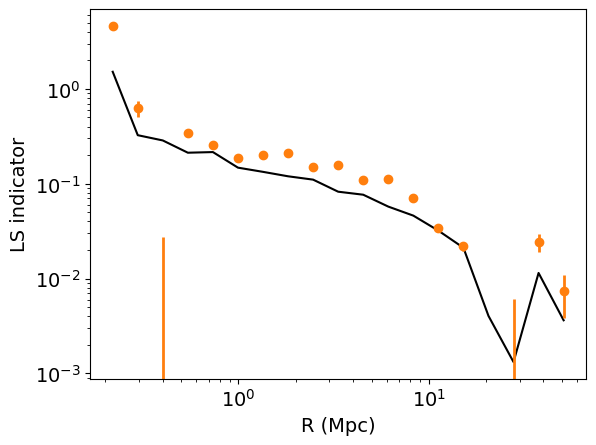

In [49]:
factor = cosmo.kpc_comoving_per_arcmin(0.08).to(u.Mpc/u.deg).value
plt.plot(bin_centers_all*factor, tpc_all, color= 'k')

#plt.plot(bin_centers_all, np.nanmean(np.where(tpc_mergers>-1.,tpc_mergers, np.nan),axis=0),)
ek.errorbar(
    bin_centers_all*factor, 
    np.median(tpc_ovlm,axis=0), 
    ylow=np.quantile(tpc_ovlm, 0.16, axis=0), 
    yhigh=np.quantile(tpc_ovlm, 0.84, axis=0), 
    color= 'C1', lw=2)
#ek.loglog()
show_benchmark = False
if show_benchmark:
    plt.scatter(bin_centers_all*factor, benchmark, color= 'grey')
    linthresh=0.01
    plt.yscale('symlog', linthresh=linthresh)
    plt.axhline(linthresh, color='lightgrey', ls=':')
else:
    plt.yscale('log')
plt.xscale('log')
plt.axhline(0., color='grey')
plt.xlabel('R (Mpc)')
plt.ylabel('LS indicator')